# Data Preparation

JSON Annotated images to binary masks
(run only once)

In [ ]:
%%capture
!pip install labelme
!python labelme2voc.py Annotated_data ds --labels labels.txt
!python prepare_data.py

Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

IMG_WIDTH x IMG_HEIGHT will be the dimensions we traiin the model on

In [ ]:
IMG_HEIGHT = 192
IMG_WIDTH = 192
IMG_CHANNELS = 1

List of file names
*   350 train images
*   38 test images

In [ ]:
train_image_id_list = [f'{i}.jpg' for i in range(0,350)]
train_mask_id_list = [f'{i}.png' for i in range(0,350)]
test_image_id_list = [f'{i}.jpg' for i in range(350,388)]
test_mask_id_list = [f'{i}.png' for i in range(350,388)]

In [ ]:
train_images = np.zeros((len(train_image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
train_masks = np.zeros((len(train_image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
test_images = np.zeros((len(test_image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_masks = np.zeros((len(test_image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

Training and test dataset

In [ ]:
for i, image_id in enumerate(train_image_id_list):    
    path_image = 'Dataset/Images/' + image_id   
    image = imread(path_image)
    image = image[:,:,0]
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = np.expand_dims(image, axis=-1)
    train_images[i] = image

for i, mask_id in enumerate(train_mask_id_list):
    path_mask = 'Dataset/Masks/' + mask_id
    mask = imread(path_mask)
    mask = mask[:,:,0]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.expand_dims(mask, axis=-1)
    train_masks[i] = mask

for i, image_id in enumerate(test_image_id_list):
    path_image = 'Dataset/Images/' + image_id
    image = imread(path_image)
    image = image[:,:,0]
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    image = np.expand_dims(image, axis=-1)
    test_images[i] = image

for i, mask_id in enumerate(test_mask_id_list):
    path_mask = 'Dataset/Masks/' + mask_id
    mask = imread(path_mask)
    mask = mask[:,:,0]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np.expand_dims(mask, axis=-1)
    test_masks[i] = mask

A look at the training image and segmentation mask

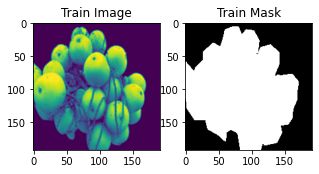

In [ ]:
plt.figure(figsize=(5,10))
plt.axis('Off')

plt.subplot(1,2,1)
plt.title('Train Image', fontsize=12)
test_image = train_images[1, :, :, 0]
plt.imshow(test_image)

plt.subplot(1,2,2)
plt.title('Train Mask', fontsize=12)
test_image = train_masks[1, :, :, 0]
plt.imshow(test_image, cmap='gray')

# Define Model
Importing libraries

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Model architecture

In [ ]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255.0) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.Precision( thresholds=0.5))

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 192, 192, 1) 0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 192, 192, 1)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 192, 192, 16) 160         lambda_9[0][0]                   
__________________________________________________________________________________________________
dropout_81 (Dropout)            (None, 192, 192, 16) 0           conv2d_171[0][0]                 
____________________________________________________________________________________________

# Training
The best model is saved as 'model.h5' in current working directory.

In [ ]:
filepath = "192.h5"
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [earlystopper, checkpoint]
history = model.fit(train_images, train_masks, validation_split=0.1, batch_size=32, epochs=50)#, callbacks=callbacks_list)

Epoch 1/50
10/10 [==============================] - 6s 296ms/step - loss: 0.7642 - precision_1: 0.4470 - val_loss: 0.6624 - val_precision_1: 0.4766
Epoch 2/50
10/10 [==============================] - 2s 180ms/step - loss: 0.6663 - precision_1: 0.4886 - val_loss: 0.8759 - val_precision_1: 0.5226
Epoch 3/50
10/10 [==============================] - 2s 180ms/step - loss: 0.6695 - precision_1: 0.5325 - val_loss: 0.5646 - val_precision_1: 0.5645
Epoch 4/50
10/10 [==============================] - 2s 180ms/step - loss: 0.5656 - precision_1: 0.5743 - val_loss: 0.5333 - val_precision_1: 0.5994
Epoch 5/50
10/10 [==============================] - 2s 182ms/step - loss: 0.5334 - precision_1: 0.6063 - val_loss: 0.7105 - val_precision_1: 0.6222
Epoch 6/50
10/10 [==============================] - 2s 181ms/step - loss: 0.5381 - precision_1: 0.6277 - val_loss: 0.6305 - val_precision_1: 0.6375
Epoch 7/50
10/10 [==============================] - 2s 182ms/step - loss: 0.5167 - precision_1: 0.6418 - val_los

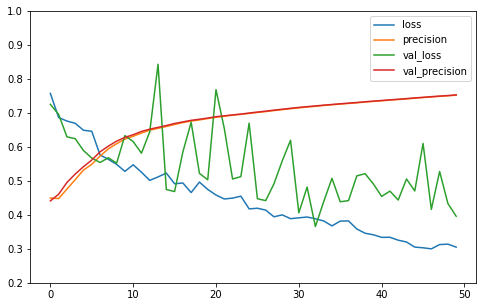

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylim(0.2,1)
plt.show()

# Testing
Load best model.

In [ ]:
model.load_weights('192.h5')

In [ ]:
test_predictions = model.predict(test_images)
test_predictions = (test_predictions >= 0.5).astype(np.uint8)

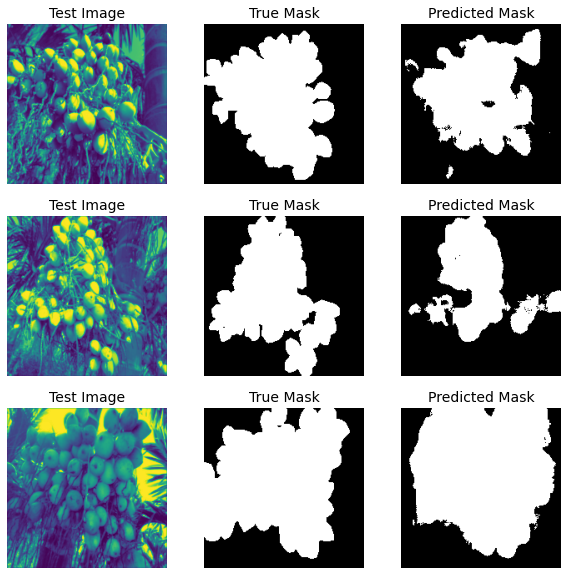

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('Off')
count = 0
for i in range(3):
  count += 1
  plt.subplot(3,3,count)
  test_image = test_images[i, :, :, 0]
  plt.imshow(test_image)
  plt.title('Test Image', fontsize=14)
  plt.axis('off')

  count += 1
  plt.subplot(3,3,count)
  test_true_mask = test_masks[i, :, :, 0]
  plt.imshow(test_true_mask, cmap='gray')
  plt.title('True Mask', fontsize=14)
  plt.axis('off')

  count += 1
  plt.subplot(3,3,count)
  test_mask = test_predictions[i, :, :, 0]
  plt.imshow(test_mask, cmap='gray')
  plt.title('Predicted Mask', fontsize=14)
  plt.axis('off')